# EOF analysis of SST, sea ice and MLD in FOCI-OpenIFS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean 
from scipy.signal import detrend as sp_detrend
from scipy import signal
from scipy import signal, stats
from scipy.stats import chi2
import seaborn as sns
import string

from eofs.xarray import Eof

In [2]:
from dask.distributed import Client, LocalCluster, wait

In [3]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

In [4]:
client

Client Scheduler: tcp://127.0.0.1:43561 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


## Choose dark mode? 

In [5]:
plt.style.use('default')
dark=''
#plt.style.use('dark_background')
#dark='_dark'

## User functions

In [6]:
def autocorr(x,lags):
    '''Compute autocorrelation for lags'''
    corr = [1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

def detrend(ds, dim="time"):
    return xr.apply_ufunc(
        sp_detrend,
        ds.dropna(dim),
        input_core_dims=[[dim]],
        output_core_dims=[[dim]],
    )

def my_psd(data, dim='time', Nw=768, norm=True, p_list=[0.95, 0.99]):
    """
    Compute power spectrum of time series. 
    Splits data into overlapping windows, 
    each with a Hann function. 
    
    Also computes red spectrum with 95 and 99 
    percentiles to check significance of peaks. 
    
    For background, see
    Torrence & Compo, BAMS 1998
    https://cobblab.eas.gatech.edu/seminar/torrence&compo98.pdf
    and 
    Hartmann lecture notes and examples
    https://atmos.washington.edu/~dennis/552_Notes_4.pdf
    https://atmos.uw.edu/~breth/classes/AS552/matlab/lect/html/nino3.html#7
    
    Input: 
    data - 1D time series
    dim - dimension name
    Nw - length of window in time steps
    
    Output: 
    freq - Frequencies
    ps - Power spectrum 
    ps_red - Red spectrum 
    ps_red95 - Red spectrum (95th percentile)
    ps_red99 - Red spectrum (99th percentile)
    """
    
    # if not even number of steps, skip first step
    if np.mod(len(data[dim]),2) == 0:
        data = data[1:]
    
    # size of array
    N = len(data[dim])
    print(' Size of array: %d' % (N,))
    
    # lag-1 autocorr
    # this is needed to compute red spectrum 
    [r1,r2] = autocorr( data.data, [1,2] )
    # alpha is from Torrence & Compo (below eq 16)
    alpha = (r1 + np.sqrt(r2)) / 2.
    
    # Compute total variance in data
    variance = (data**2).mean(dim).data
    
    # Set window length (in steps)
    #Nw = 768 
    
    Nw2 = Nw/2 # Half-window length
    # We choose windows so that there is some overlap
    nwin = int( np.floor((N)/Nw2)-1 ) # Number of half-overlapping
                                      # windows of Nwyr2 yrs used
    
    # Time vector for the window
    t = np.arange(0,Nw) 
    # Window function 
    w = 0.5*(1-np.cos(2*np.pi*(t-1)/Nw)) # Hann window of length Nwyr;
    varw = 3/8. # Mean-square value of taper function w (used to
                # renormalize power spectrum).
    
    # Make array to put windowed data in
    dataw = np.zeros((Nw,nwin)) # Windowed and tapered SSTA
    
    for iw in range(0,nwin):
        
        # Put windowed data in array
        _ioff = iw * Nw/2 # Index offset
        #print(_ioff)
        ioff = int(_ioff)
        dataw[:,iw] = w * data[ioff:(ioff+Nw)]
    
    # Now do fft over first dimension (which is time)
    # Second dimension is nwindows
    datahat = np.fft.fft(dataw, axis=0)
    
    # Set up frequency array [1/unit]
    # [0, 1, .. Nw/2-1, -Nw/2, ... -1]
    # Frequency is then Mw/Nw 
    Mw1 = np.arange(0,Nw/2) 
    Mw2 = np.arange(-Nw/2,0) 
    Mw = np.hstack([Mw1,Mw2]) 
    freq = Mw/Nw
    
    # Normalise power spectrum by dividing with window length
    # The FFT is a sum in time, so dividing by N is required
    # Then take square of abs to get power
    # And scale the variance due to the windowing 
    Sw = np.abs(datahat/Nw)**2 / varw
    
    # Average over windows
    Swav = np.mean(Sw,axis=1)
    
    # Normalise Sw 
    if norm:
        Swnorm = Swav * Nw/(2 * variance)
    else:
        Swnorm = Swav
    
    # Normalized red noise spectrum with same variance as data
    alpha = (r1 + np.sqrt(r2)) / 2.
    # Eq 16 in Torrence & Compo 1998
    ps_red = (1 - alpha**2) / (1 + alpha**2 - 2 * alpha * np.cos(2*np.pi*Mw/Nw))
    
    if not norm:
        ps_red = ps_red * (2 * variance)/Nw
    
    
    # Significance using chi-squared 
    # Multiply ps_red by chi2 stat (Torrence & Compo, 1998)
    ps_red_chi = np.zeros((len(p_list), ps_red.shape[0]))
    for ji, p in enumerate(p_list):
        q = chi2.ppf(p, df=2)
        ps_red_chi[ji,:] = ps_red * q
    
    return freq, Swnorm, ps_red, ps_red_chi, Nw

## Read OpenIFS

In [7]:
# Get the NEMO mesh (points to my personal dir, you should change to yours!)
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
    nemo_mesh = '/data/user/jkjellsson/orca05_mesh_mask.nc'
elif machine == 'nesh':
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    esmdir2 = '/gxfs_work1/geomar/smomw352/esm-slask/'
    nemo_mesh = '/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc'

In [8]:
exp_list = ['FOCI_GJK001','FOCI_GJK006']
time_list = [slice('1850-01-01','2850-01-01'),slice('2850-01-01','4000-01-01')]

In [9]:
# OpenIFS surface
ds_sfc_1y_all = []
for exp,time in zip(exp_list,time_list):
    sfc = '%s/%s/outdata/oifs/1y/*1y*regular_sfc.nc' % (esmdir,exp)
    print(sfc)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_sfc_1y_all.append(ds_sfc)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/1y/*1y*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/oifs/1y/*1y*regular_sfc.nc


In [10]:
ds_sfc_1y = xr.concat( ds_sfc_1y_all, dim='time' )

## Read lsm 

In [11]:
file = '%s/%s/outdata/oifs/lsm_regular.nc' % (esmdir,exp)
ds_lsm = xr.open_dataset(file, use_cftime=True)
lsm = ds_lsm['lsm'][0,:,:]

## EOFs

In [12]:
# Apply running mean
_sst = ds_sfc_1y['sstk']
sst_lp = _sst.rolling(time=11,center=True).mean().dropna(dim='time').fillna(0)
sst_anom = sst_lp - sst_lp.mean('time')

In [13]:
# Regrid from 0,360 to -180,180
# We use sortby to make sure that -179 is the first column and 179 is the last
sst_anom_180 = sst_anom.assign_coords(lon=(((sst_anom.lon + 180) % 360) - 180)).sortby('lon')

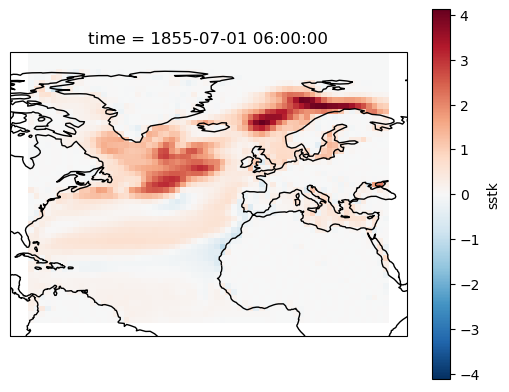

In [14]:
sst_anom_cut = sst_anom_180.sel(lon=slice(-80,40), lat=slice(0,90))
fig1, ax1 = plt.subplots(1,1,subplot_kw={'projection':ccrs.PlateCarree()})
sst_anom_cut.isel(time=0).plot(ax=ax1, transform=ccrs.PlateCarree())
ax1.coastlines()

In [15]:
# Detrend (requires load first)
_detrend = detrend(sst_anom_cut.load())
# Make sure time is first dimension (this is needed for EOF functions)
sst_anom_cut_detrend = _detrend.transpose("time",...)

In [16]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(sst_anom_cut_detrend.coords['lat'].values)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]

# The SVD solver does not work on lazy data, so we must load!
solver = Eof(sst_anom_cut_detrend.load(), weights=wgts)

In [17]:
# Retrieve the leading EOF, expressed as the covariance between the leading PC
# time series and the input anomalies at each grid point.
eofs = solver.eofs(neofs=10, eofscaling=1)
pcs = solver.pcs(npcs=10, pcscaling=1)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/plot/facetgrid.py:392: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


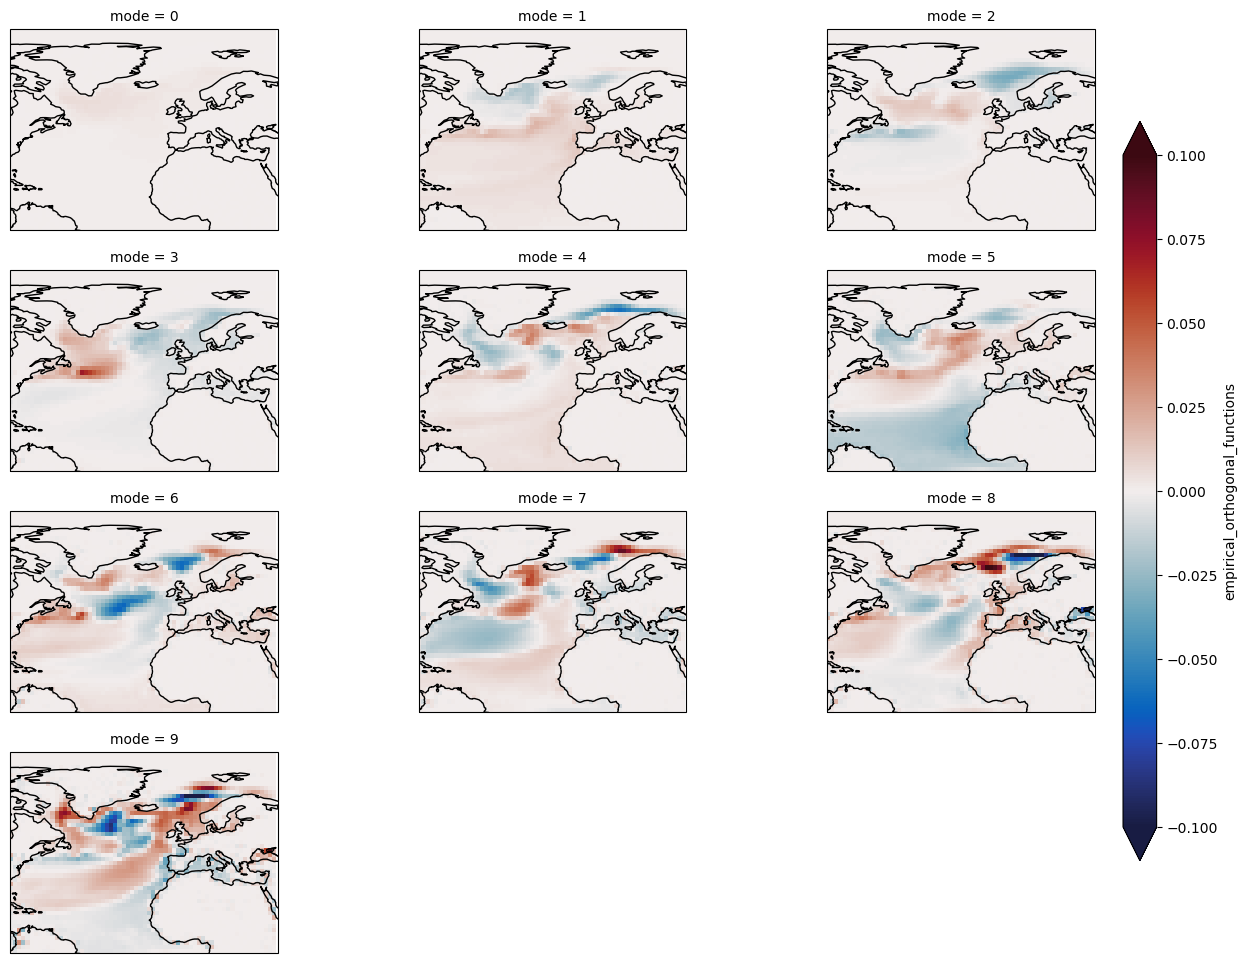

In [18]:
cbar_kwargs={'shrink':0.8, 'pad':0.02}

p = eofs.plot(transform=ccrs.PlateCarree(), 
              col='mode', col_wrap=3, 
              vmin=-0.1, vmax=0.1,
              cmap=cmocean.cm.balance,
              figsize=(18,12),
              rasterized=True,
              cbar_kwargs=cbar_kwargs,
              subplot_kws={'projection':ccrs.PlateCarree()})

for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent([-80,40, 0,90])
    
p.fig.savefig('figures/EOFs_NAtl_sst.pdf',format='pdf',dpi=150)

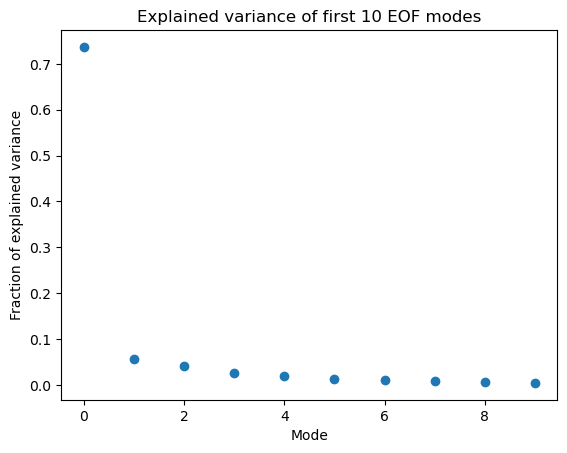

In [19]:
vf = solver.varianceFraction(neigs=10)
fig1,ax1=plt.subplots(1,1)
ax1.scatter(vf.mode, vf.data)
ax1.set_xlabel('Mode')
ax1.set_ylabel('Fraction of explained variance')
ax1.set_title('Explained variance of first 10 EOF modes')
fig1.savefig('figures/EOF_NAtl_explained_variance.pdf',format='pdf')

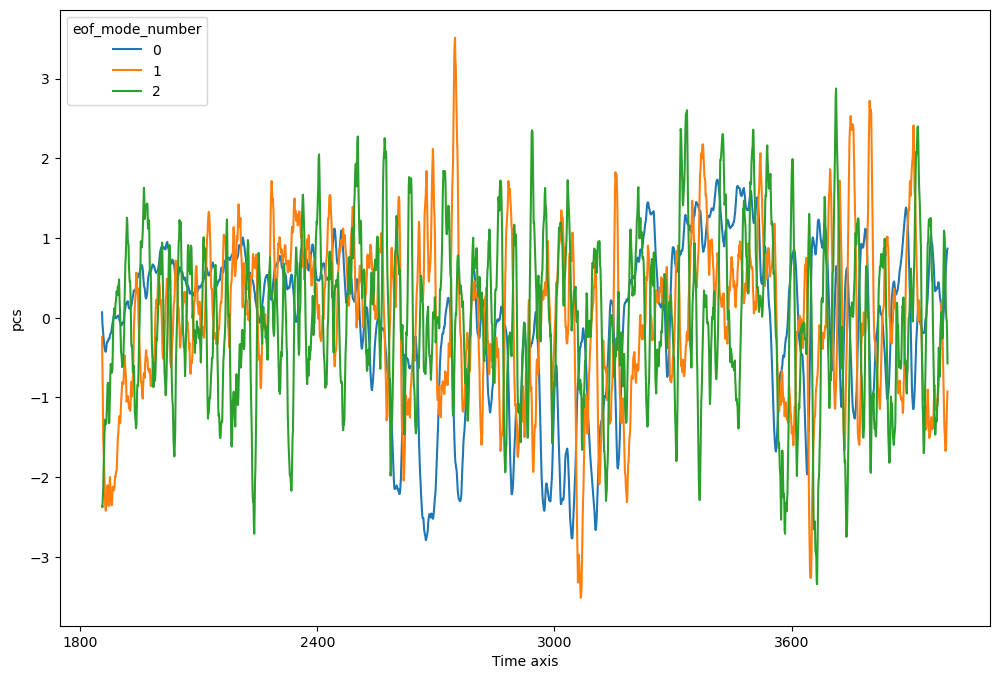

In [20]:
fig1, ax1 = plt.subplots(1,1,figsize=(12,8))
pcs.sel(mode=slice(0,2)).plot.line(ax=ax1, hue='mode')

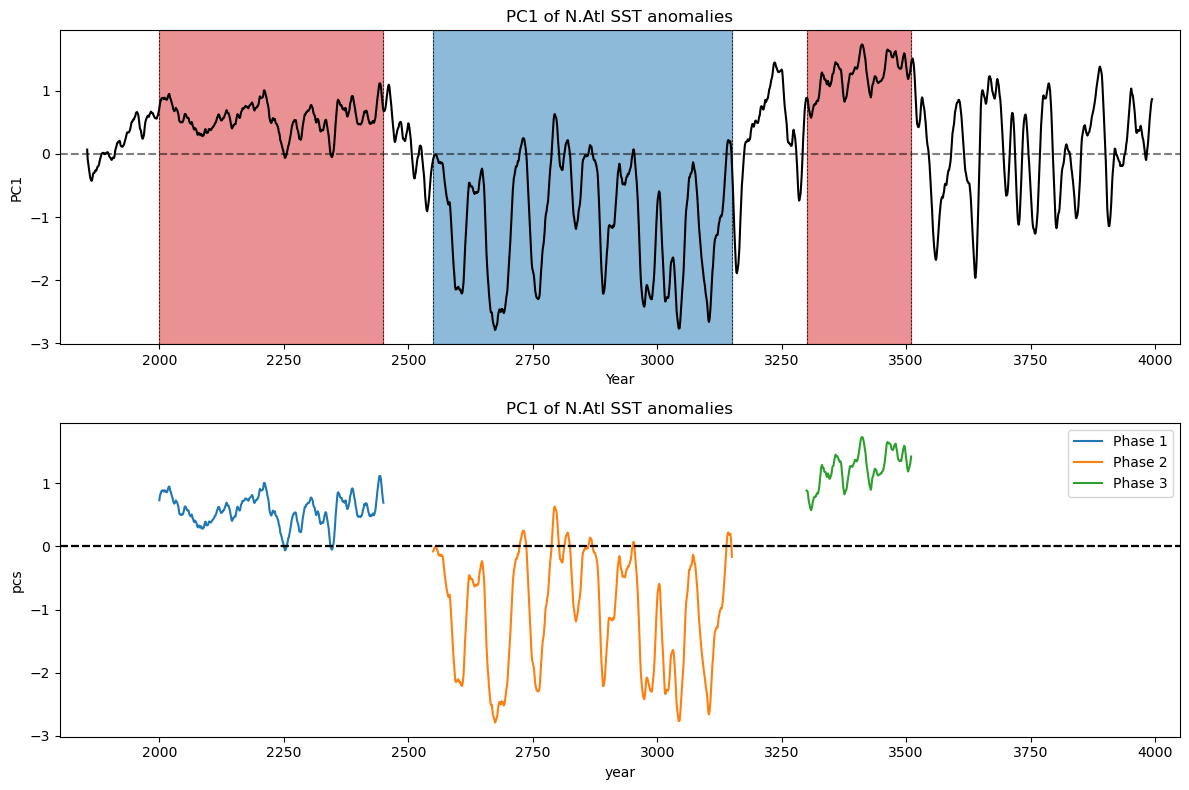

In [21]:
fig1, axs1 = plt.subplots(2,1,figsize=(12,8))
ax1 = axs1.flat

pc = pcs.groupby('time.year').mean('time').sel(mode=0)
pc.plot.line(ax=ax1[0], hue='mode', c='k')

ax1[0].axhline(y=0,linestyle='--',c='k',alpha=0.5)
ax1[0].set_title('PC1 of N.Atl SST anomalies')
#ax1[0].set_ylim([-45, 45])
ax1[0].set_ylabel('PC1')
ax1[0].set_xlabel('Year')

periods = [ [2000,2450], [2550,3150], [3300,3510] ]
names = ['Phase 1', 'Phase 2', 'Phase 3']

colours = ['tab:red','tab:blue','tab:red']

for jp, per in enumerate(periods):
    ax1[0].axvspan(per[0], per[1], alpha=0.5, color=colours[jp])
    for p in per:
        ax1[0].axvline(x=p,linestyle='--',c='k',lw=0.5)
        #ax1[0].axvline(x=p,linestyle='--',c='k',lw=0.5)
        #ax1[0].axvline(x=p,linestyle='--',c='k',lw=0.5)

for j, (per, name) in enumerate( zip(periods, names) ):
    
    ax = ax1[1]
    pc.sel(year=slice(per[0],per[1])).plot(ax=ax, label=name)
    ax.axhline(y=0,linestyle='--',c='k')

ax1[1].legend()
ax1[1].set_title('PC1 of N.Atl SST anomalies')
    
for ax in ax1:
    ax.set_xlim([1800,4050])
    
fig1.tight_layout()
fig1.savefig('figures/PC1_Natl%s.pdf' % (dark,),format='pdf')

In [22]:
# Save EOFs and PCs to disk
ds_pc = pcs.to_dataset()
ds_eof = eofs.to_dataset()
ds = xr.merge([ds_eof, ds_pc])
ds.to_netcdf('data/EOF_PC_10_NAtl_1850-3999.nc')

In [23]:
_ds = xr.open_dataset('data/EOF_PC_10_NAtl_1850-3999.nc',use_cftime=True)
pcs = _ds['pcs']
pcs

<xarray.DataArray 'pcs' (time: 2140, mode: 10)>
array([[ 0.068196, -0.240942, -2.359505, ...,  1.428464, -0.102007, -0.614834],
       [-0.079896, -0.57817 , -2.377252, ...,  1.187905,  0.121446, -1.169128],
       [-0.144537, -1.002671, -2.243135, ...,  0.614609,  0.535457, -1.58488 ],
       ...,
       [ 0.793164, -1.239776, -0.033121, ..., -0.183768,  0.380295, -0.691029],
       [ 0.844954, -1.050995, -0.217311, ...,  0.114797,  0.024411, -0.703643],
       [ 0.867374, -0.925178, -0.572975, ...,  0.264066, -0.309504, -0.7826  ]])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9
  * time     (time) object 1855-07-01 06:00:00 ... 3994-07-01 06:00:00

## Correlate PC1 with global SST

In [24]:
_sst = detrend(sst_anom_180.load()).transpose('time',...)

def pcorr(x,y):
    N = len(x['time'])
    xa = x - x.mean('time')
    ya = y - y.mean('time')
    
    # covariance
    cov = (xa*ya).sum('time') / N
    
    # pearson correlation (cov / (xstd*ystd))
    corr = cov / (xa.std('time',ddof=1) * ya.std('time',ddof=1))
    
    # regression (cov / (xstd^2))
    reg = cov/(xa.std('time',ddof=1)**2)
    
    return corr, reg
    

corr, reg = pcorr(pcs.sel(mode=0), _sst)
corr.compute()
reg.compute()

<xarray.DataArray (lat: 96, lon: 192)>
array([[-2.30863523e-04, -1.30877896e-04, -3.45021989e-05, ...,
        -5.25120434e-04, -4.22148702e-04, -3.25894365e-04],
       [ 1.06905164e-03,  1.42053026e-03,  1.77133781e-03, ...,
         2.19680446e-05,  3.69559085e-04,  7.17947651e-04],
       [-2.28207770e-03, -5.83949595e-04, -3.92025155e-03, ...,
        -1.25134950e-02, -4.63088445e-03, -3.63129522e-03],
       ...,
       [ 1.10708893e-03,  1.05927096e-03,  1.00299698e-03, ...,
         1.26448838e-03,  1.20889924e-03,  1.15729965e-03],
       [ 1.11611310e-03,  1.07826715e-03,  1.02897136e-03, ...,
         1.24480527e-03,  1.20789988e-03,  1.15986973e-03],
       [ 1.00352353e-03,  9.84959456e-04,  9.66293662e-04, ...,
         1.05783801e-03,  1.03986871e-03,  1.02207189e-03]])
Coordinates:
    mode     int64 0
  * lon      (lon) float32 -179.1 -177.2 -175.3 -173.4 ... 175.3 177.2 179.1
  * lat      (lat) float32 -89.06 -87.19 -85.31 -83.44 ... 85.31 87.19 89.06

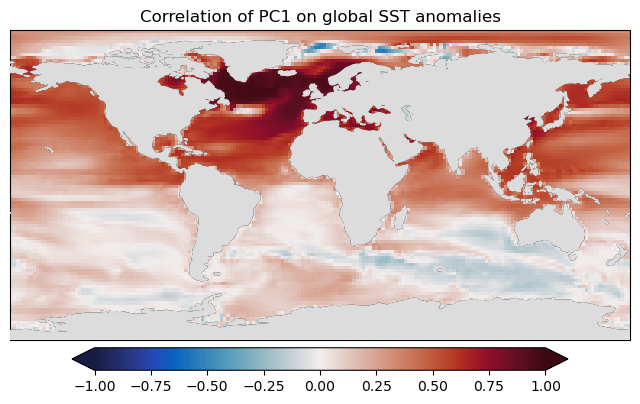

In [25]:
fig1, ax1 = plt.subplots(1,1,figsize=(8,5),subplot_kw={'projection':ccrs.PlateCarree()})
corr.plot(ax=ax1, 
          vmin=-1,vmax=1,
          cmap=cmocean.cm.balance,
          transform=ccrs.PlateCarree(),
          cbar_kwargs={'orientation':'horizontal','extend':'both','shrink':0.8,'pad':0.02},
          rasterized=True)
ax1.coastlines()
ax1.add_feature(cfeature.LAND, zorder=100, color='Gainsboro')
ax1.set_title('Correlation of PC1 on global SST anomalies')
fig1.savefig('figures/PC1_corr_SST%s.pdf' % (dark,),format='pdf',dpi=150)

In [26]:
# Save to netcdf
corr.name = 'r_sst'
reg.name = 'a_sst'
_ds1 = corr.to_dataset()
_ds2 = reg.to_dataset()
_ds = xr.merge([_ds1,_ds2])
_ds.to_netcdf('data/corr_SST_PC1.nc')

## PSD of PC1

(2140,)
 Size of array: 2139
(1000,) (1000,) (1000,) 1000
[ 71.42857143  66.66666667  29.41176471  27.02702703 -27.02702703
 -29.41176471 -66.66666667 -71.42857143]


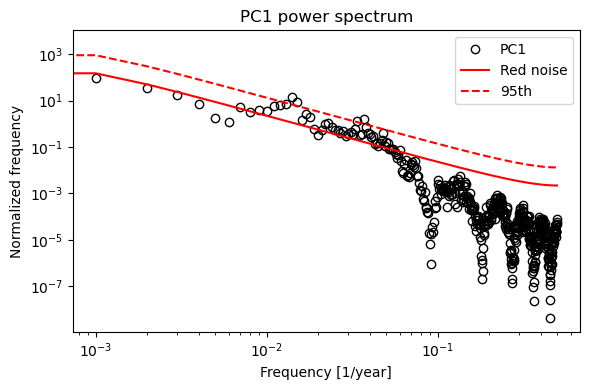

In [27]:
print(pcs.sel(mode=0).shape)

# Call psd function
freq, ps, ps_red, ps_red_chi, Nw = my_psd(pcs.sel(mode=0), Nw=1000, dim='time', p_list=[0.95, 0.99])
print(freq.shape, ps.shape, ps_red.shape, Nw)

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.loglog(freq, ps,'ko', fillstyle='none', label='PC1')
ax.loglog(freq[0:int(Nw/2)], ps_red[0:int(Nw/2)],'r-', label='Red noise')
ax.loglog(freq[0:int(Nw/2)], ps_red_chi[0,0:int(Nw/2)],'r--', label='95th')
ax.set_ylabel('Normalized frequency')
ax.set_xlabel('Frequency [1/year]')
ax.set_title('PC1 power spectrum')
ax.legend()

# Print frequencies with peaks above 95th level
ii = np.where(ps > ps_red_chi[0,:])[0]
sign_freqs = freq[ii]
print(1./sign_freqs)

fig.tight_layout()

## 3-panel plot of PC1 time series, regression, and PSD

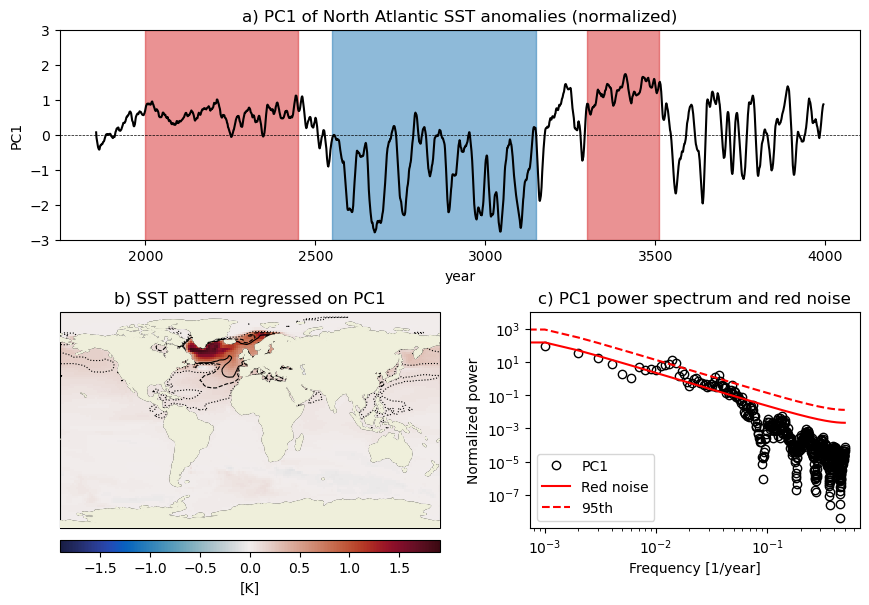

In [50]:
def drei_panels():
    
    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_axes([0.1, 0.6, 0.8, 0.35])
    ax2 = fig.add_axes([0.1, 0.12, 0.38, 0.36], projection=ccrs.PlateCarree())
    cax2 = fig.add_axes([0.1, 0.08, 0.38, 0.02])
    ax3 = fig.add_axes([0.57, 0.12, 0.33, 0.36])
    
    return fig, ax1, ax2, ax3, cax2

fig, ax1, ax2, ax3, cax2 = drei_panels()

#drei_panels(, reg, corr, freq[0:n2], fft_a[0:n2])    

# Plot time series of PC1
_pc = pcs.sel(mode=0).groupby('time.year').mean('time')
pc.plot(ax=ax1, color='k' )
ax1.axhline(y=0, linestyle='--', color='k', lw=0.5)

# Indicate cold and warm periods
colours = ['tab:red','tab:blue','tab:red']

for jp, per in enumerate(periods):
    ax1.axvspan(per[0], per[1], alpha=0.5, color=colours[jp])

# Titles and labels
ax1.set_title('a) PC1 of North Atlantic SST anomalies (normalized)')
ax1.set_ylabel('PC1')
ax1.set_ylim([-3,3])    
    
# Plot SST regressed on PC1
cbar_kwargs = {'orientation':'horizontal', 'label':'[K]'}
reg.plot.pcolormesh(ax=ax2, 
                    cbar_kwargs=cbar_kwargs,
                    transform=ccrs.PlateCarree(), 
                    cmap=cmocean.cm.balance,
                    rasterized=True,
                    cbar_ax=cax2)

# Draw contours of explained variance on top
(corr**2).plot.contour(ax=ax2, levels=[0.7], colors='k', linestyles='solid', linewidths=0.8)
(corr**2).plot.contour(ax=ax2, levels=[0.5], colors='k', linestyles='dashed', linewidths=0.8)
(corr**2).plot.contour(ax=ax2, levels=[0.3], colors='k', linestyles='dotted', linewidths=0.8)

# Add coastlines and land
ax2.coastlines()
ax2.add_feature(cfeature.LAND, zorder=100)
#ax2.set_adjustable('datalim')
ax2.set_aspect('auto')

# Set title
ax2.set_title('b) SST pattern regressed on PC1')

# Plot Power spectrum of PC1
ax3.loglog(freq, ps,'ko', fillstyle='none', label='PC1')
ax3.loglog(freq[0:int(Nw/2)], ps_red[0:int(Nw/2)],'r-', label='Red noise')
ax3.loglog(freq[0:int(Nw/2)], ps_red_chi[0,0:int(Nw/2)],'r--', label='95th')
ax3.set_ylabel('Normalized power')
ax3.set_xlabel('Frequency [1/year]')
ax3.set_title('c) PC1 power spectrum and red noise')
ax3.legend(loc=3)

fig.savefig('figures/Fig_PC1.pdf',format='pdf', dpi=150)

## EOF of turbulent heat flux

In [29]:
# Apply running mean
_thf = ds_sfc_1y['sshf'] + ds_sfc_1y['slhf']
thf_lp = _thf.rolling(time=11,center=True).mean().dropna(dim='time').fillna(0)
thf_anom = thf_lp - thf_lp.mean('time')

In [30]:
def make_eofs(data):
    
    # Regrid from 0,360 to -180,180
    # We use sortby to make sure that -179 is the first column and 179 is the last
    _anom_180 = data.assign_coords(lon=(((data.lon + 180) % 360) - 180)).sortby('lon')
    
    _anom_cut = _anom_180.sel(lon=slice(-80,40), lat=slice(0,90))
    fig1, ax1 = plt.subplots(1,1,subplot_kw={'projection':ccrs.PlateCarree()})
    _anom_cut.isel(time=0).plot(ax=ax1, transform=ccrs.PlateCarree())
    ax1.coastlines()
    
    # Detrend (requires load first)
    _detrend = detrend(_anom_cut.load())
    # Make sure time is first dimension (this is needed for EOF functions)
    _anom_cut_detrend = _detrend.transpose("time",...)
    
    # Create an EOF solver to do the EOF analysis. Square-root of cosine of
    # latitude weights are applied before the computation of EOFs.
    coslat = np.cos(np.deg2rad(_anom_cut_detrend.coords['lat'].values)).clip(0., 1.)
    wgts = np.sqrt(coslat)[..., np.newaxis]
    
    # The SVD solver does not work on lazy data, so we must load!
    solver = Eof(_anom_cut_detrend.load(), weights=wgts)
    
    return solver

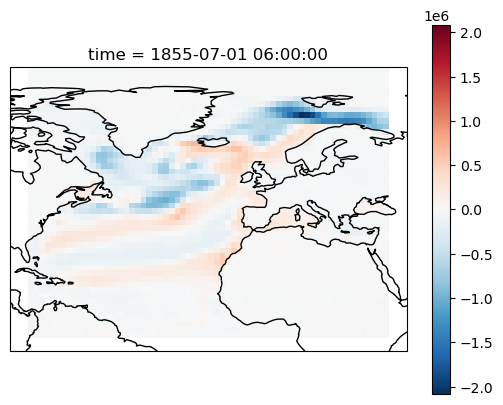

In [31]:
thf_solver = make_eofs(thf_anom)

In [32]:
def plot_10_eofs(solver):
    # Retrieve the leading EOF, expressed as the covariance between the leading PC
    # time series and the input anomalies at each grid point.
    eofs = solver.eofs(neofs=10, eofscaling=1)
    pcs = solver.pcs(npcs=10, pcscaling=1)
    
    cbar_kwargs={'shrink':0.8, 'pad':0.02, 'extend':'both'}
    
    p = eofs[0:9].plot(transform=ccrs.PlateCarree(), 
                      col='mode', col_wrap=3, 
                      #vmin=-0.1, vmax=0.1,
                      cmap=cmocean.cm.balance,
                      figsize=(18,12),
                      rasterized=True,
                      cbar_kwargs=cbar_kwargs,
                      subplot_kws={'projection':ccrs.PlateCarree()})
    
    for ax in p.axes.flat:
        ax.coastlines()
        ax.set_extent([-80,40, 0,90])
    
    p.fig.savefig('figures/EOFs_NAtl_eofs.pdf',format='pdf',dpi=150)
    
    vf = solver.varianceFraction(neigs=10)
    fig1,ax1=plt.subplots(1,1)
    ax1.scatter(vf.mode, vf.data)
    ax1.set_xlabel('Mode')
    ax1.set_ylabel('Fraction of explained variance')
    ax1.set_title('Explained variance of first 10 EOF modes')
    fig1.savefig('figures/EOF_NAtl_explained_variance.pdf',format='pdf')
    
    return eofs, pcs

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/plot/facetgrid.py:392: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


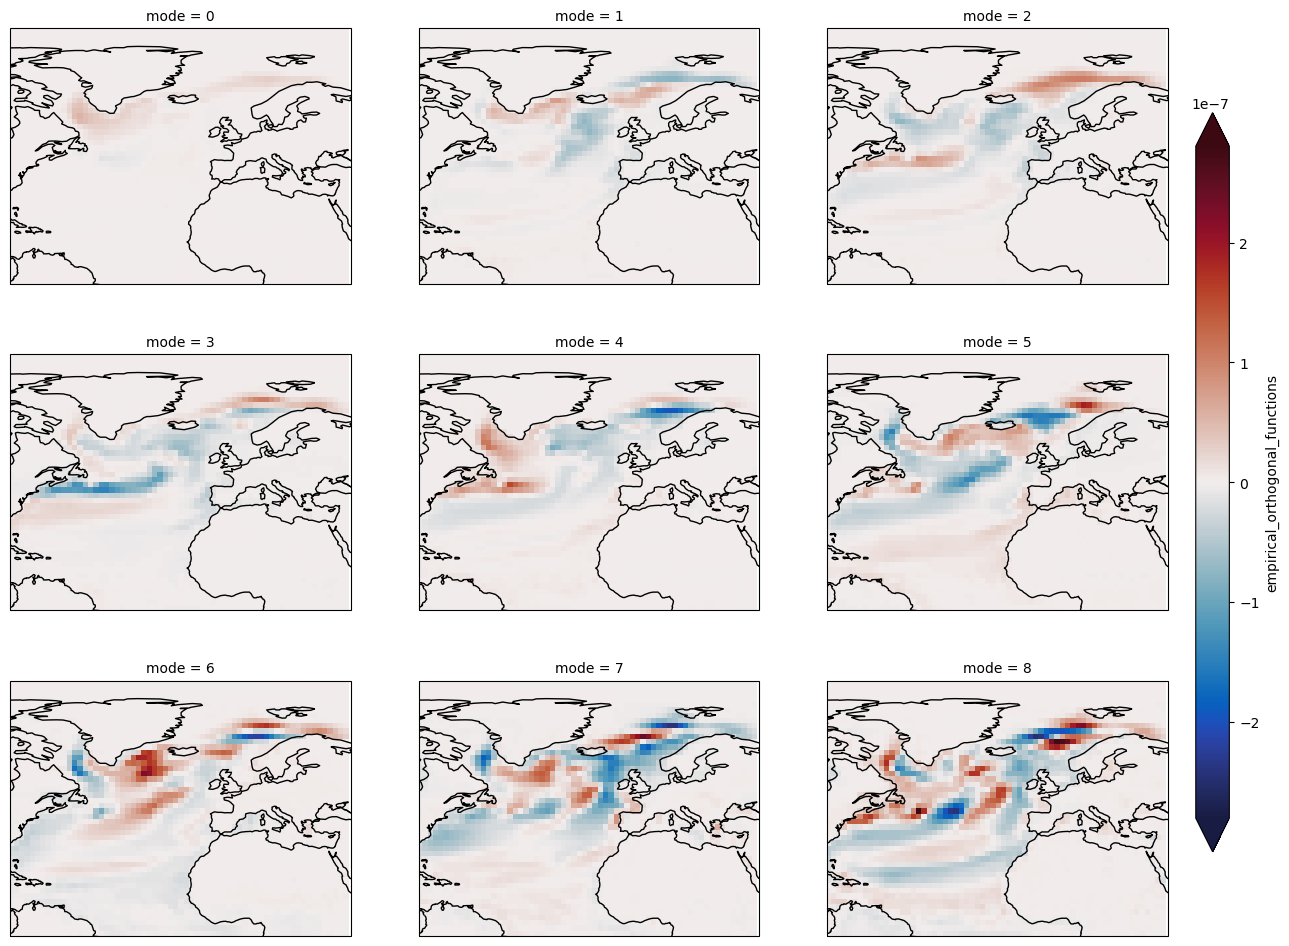

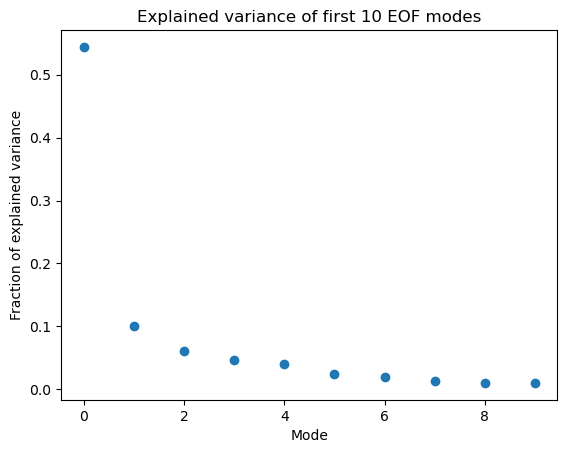

In [33]:
thf_eofs, thf_pcs = plot_10_eofs(thf_solver)

Text(0.5, 0, 'Year')

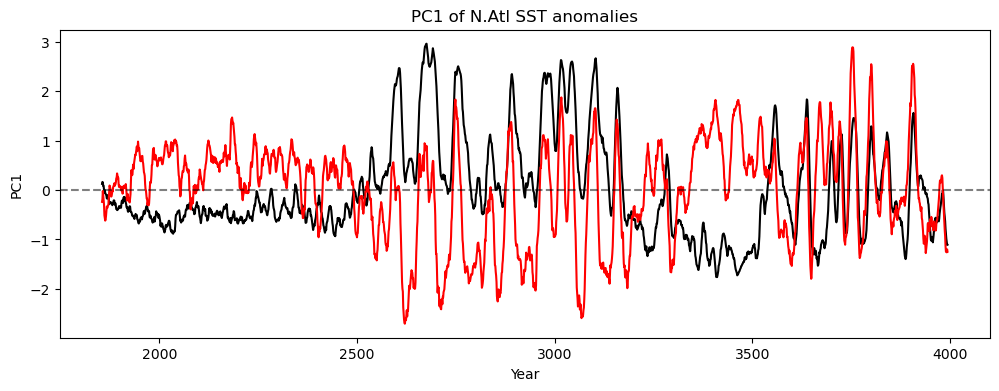

In [34]:
fig1, ax1 = plt.subplots(1,1,figsize=(12,4))

pc1 = thf_pcs.groupby('time.year').mean('time').sel(mode=0)
pc2 = thf_pcs.groupby('time.year').mean('time').sel(mode=1)
pc1.plot.line(ax=ax1, hue='mode', c='k')
pc2.plot.line(ax=ax1, hue='mode', c='r')

ax1.axhline(y=0,linestyle='--',c='k',alpha=0.5)
ax1.set_title('PC1 of N.Atl SST anomalies')
ax1.set_ylabel('PC1')
ax1.set_xlabel('Year')

In [35]:
# Save EOFs and PCs to disk
ds_pc = thf_pcs.to_dataset()
ds_eof = thf_eofs.to_dataset()
ds = xr.merge([ds_eof, ds_pc])
ds.to_netcdf('data/EOF_PC_10_THF_NAtl_1850-3999.nc')

In [36]:
_ds = xr.open_dataset('data/EOF_PC_10_THF_NAtl_1850-3999.nc',use_cftime=True)
thf_pcs = _ds['pcs']
thf_eofs = _ds['eofs']
thf_pcs

<xarray.DataArray 'pcs' (time: 2140, mode: 10)>
array([[ 0.124973, -0.238189, -2.823347, ...,  0.046441, -1.421871,  2.125147],
       [ 0.165509, -0.178831, -2.710147, ..., -0.153428, -1.473461,  1.985764],
       [ 0.15662 , -0.018068, -2.532538, ..., -0.367017, -1.369708,  1.715328],
       ...,
       [-1.039442, -1.260182, -0.466507, ..., -0.550001, -1.863577,  0.737826],
       [-1.110478, -1.199948, -0.591995, ..., -0.53321 , -1.600874,  0.798557],
       [-1.105867, -1.246688, -0.93008 , ..., -0.083786, -1.388554,  0.676473]])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9
  * time     (time) object 1855-07-01 06:00:00 ... 3994-07-01 06:00:00

In [37]:
## Plot THF EOF and regressed on PC1 of SST

In [38]:
def lag_corr(x, y, shiftx=0, shifty=0, dim='time'):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    # Joakim: Assume we correlate AMOC and AMV. If positive AMOC anom
    # precedes positive AMV, then AMOC at year-shift is correlated with AMV at year
    # So correlation at lagx=-5 means x (AMOC) leads y (AMV). 
    if shiftx != 0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift({dim:shiftx}).dropna(dim=dim)
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if shifty!=0:
        y   = y.shift({dim:shifty}).dropna(dim=dim)
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(dim)
    ymean = y.mean(dim)
    xstd  = x.std(dim)
    ystd  = y.std(dim)
    
    #4. Compute covariance along time axis
    cov   =  ((x - xmean)*(y - ymean)).sum(dim)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    #print(tstats)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(np.abs(tstats), n-2)*2
    #print(pval)
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)
    
    #slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
    #cor   = xr.DataArray(cor, dims=cov.dims, coords=cov.coords)
    #slope   = xr.DataArray(slope, dims=cov.dims, coords=cov.coords)
    #pval   = xr.DataArray(pvalue, dims=cov.dims, coords=cov.coords)
    #stderr   = xr.DataArray(stderr, dims=cov.dims, coords=cov.coords)

    return cov,cor,slope,intercept,pval,stderr

In [39]:
def manylags(x,y, dim='time'):
    """
    Compute correlation coefficients with x variable shifted in time. 
    """
    
    # Lags to use 
    lags = np.arange(-60,61,1)
    
    # Empty lists to store result for each lag
    corr = []
    a = []
    p = []
    
    for lagx in lags:
        
        # compute correlation, pvalues etc
        # a,b are fitted for y = ax + b
        _cov, _corr, _a, _b, _p, _std = lag_corr(x, y, shiftx=lagx, dim=dim)
        
        # add lag as dimension
        _corr['lag'] = lagx
        _a['lag'] = lagx
        _p['lag'] = lagx
        
        # store results
        corr.append(_corr)
        a.append(_a)
        p.append(_p)
    
    # now we concatenate results along lag dimension
    da_corr = xr.concat(corr, dim='lag')
    da_a = xr.concat(a, dim='lag')
    da_p = xr.concat(p, dim='lag')
    
    # give variables names
    da_corr.name = 'corrcoef'
    da_a.name = 'slope'
    da_p.name = 'pval'
    
    # convert to dataset
    _d1 = da_corr.to_dataset()
    _d2 = da_a.to_dataset()
    _d3 = da_p.to_dataset()
    
    # merge all results to one dataset
    ds = xr.merge([_d1,_d2,_d3])
    
    return ds

In [40]:
def bandpass(x, run1=20, run2=100):
    
    # Bandpass
    run1, run2 = 20,100
    _x = x.groupby('time.year').mean('time').rolling(year=run1,center=True).mean() - \
         x.groupby('time.year').mean('time').rolling(year=run2,center=True).mean()
    
    return _x

In [41]:
periods = [ [2000,2450], [2550,3150], [3300,3510] ]
names = ['Warm period', 'Cold period', 'Warm period 2']

In [42]:
# time filter
_sst1 = bandpass(pcs.sel(mode=0))
_thf1 = bandpass(thf_pcs.sel(mode=0))
_thf2 = bandpass(thf_pcs.sel(mode=1))

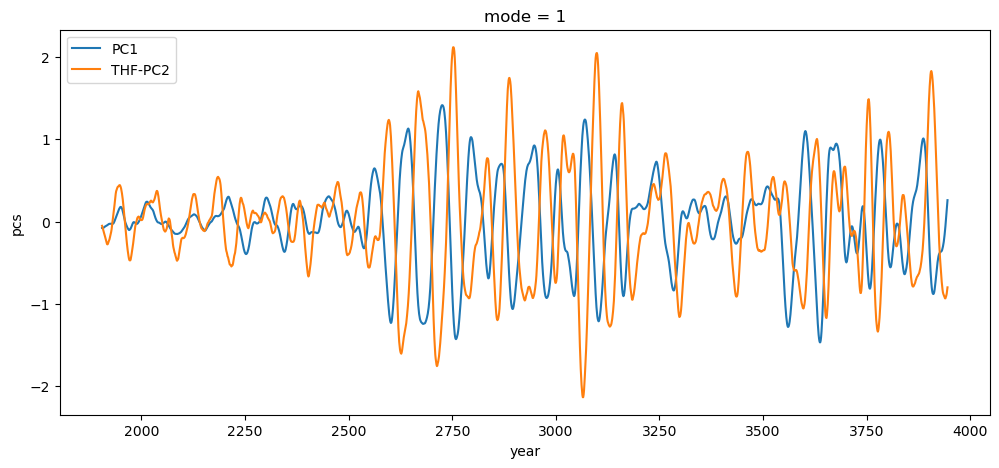

In [43]:
fig1,ax1 = plt.subplots(figsize=(12,5))
_sst1.plot(ax=ax1, label='PC1')
_thf2.plot(ax=ax1, label='THF-PC2')
ax1.legend()

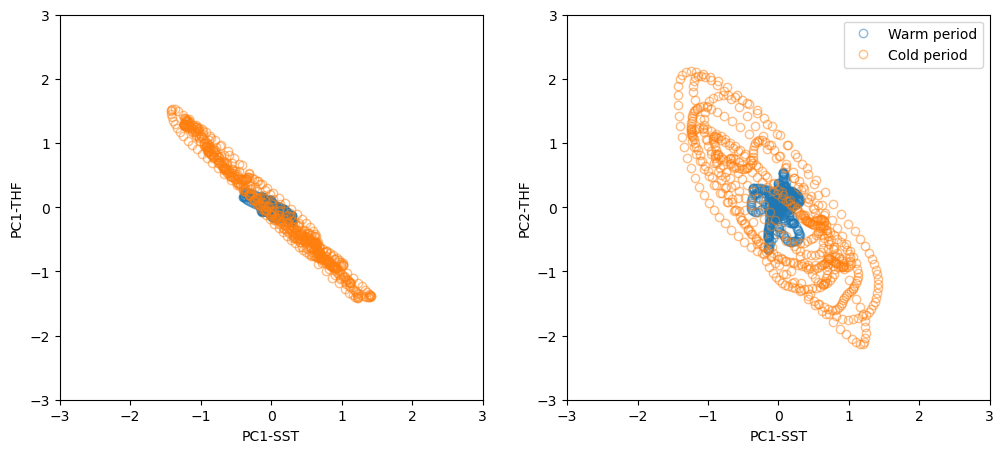

In [44]:
fig1, ax1 = plt.subplots(1,2, figsize=(12,5))

for ji, period in enumerate(periods[0:2]):
    x = _sst1.sel(year=slice(period[0],period[1])) 
    y1 = _thf1.sel(year=slice(period[0],period[1])) 
    y2 = _thf2.sel(year=slice(period[0],period[1])) 
    
    ax1[0].plot(x.data, y1.data, label=names[ji], marker='o', linestyle='none', fillstyle='none',alpha=0.5)
    ax1[0].set_xlabel('PC1-SST')
    ax1[0].set_ylabel('PC1-THF')
    ax1[0].set_xlim([-3,3])
    ax1[0].set_ylim([-3,3])
    
    l = 1
    # lag y2 by l
    ax1[1].plot(x[l:], y2.data[:-l], label=names[ji], marker='o', linestyle='none', fillstyle='none', alpha=0.5)
    ax1[1].set_xlabel('PC1-SST')
    ax1[1].set_ylabel('PC2-THF')
    ax1[1].set_xlim([-3,3])
    ax1[1].set_ylim([-3,3])
    
ax1[1].legend()

In [45]:
ds_pc1_thf1 = []
ds_pc1_thf2 = []

for period in periods[0:2]:
    _x = _sst1.sel(year=slice(period[0],period[1]))
    _y1 = _thf1.sel(year=slice(period[0],period[1]))
    _y2 = _thf2.sel(year=slice(period[0],period[1]))
    
    # correlate SST PC1 to THF PC1
    _ds1 = manylags(_x, _y1, dim='year')
    # correlate SST PC1 to THF PC2
    _ds2 = manylags(_x, _y2, dim='year')
    
    ds_pc1_thf1.append(_ds1)
    ds_pc1_thf2.append(_ds2)

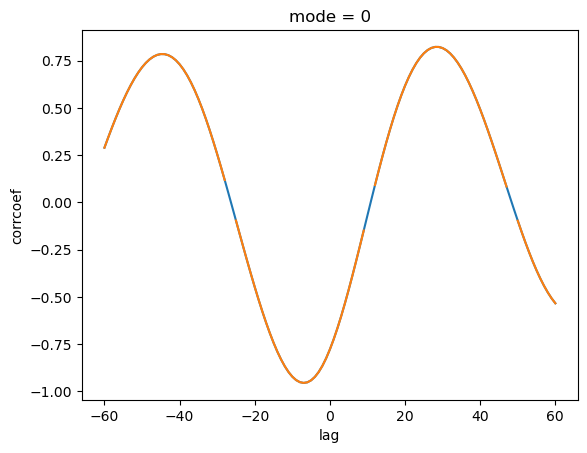

In [46]:
r = _ds2['corrcoef']
p = _ds2['pval']
r.plot()
r.where(p<0.05).plot()

In [47]:
# Correlate THF anomalies on PCs

scale = 1/(6*60*60.0)

thf_corr = []
thf_reg = []
for m in range(0,2):
    
    x = bandpass(thf_pcs.sel(mode=m))
    y = bandpass(thf_anom * scale)
    
    _cov, _cor, _a, _b, _p, _err = lag_corr(x,y, dim='year')
    
    a_180 = _a.assign_coords(lon=(((_a.lon + 180) % 360) - 180)).sortby('lon')
    cor_180 = _cor.assign_coords(lon=(((_cor.lon + 180) % 360) - 180)).sortby('lon')
    
    thf_corr.append(cor_180.compute())
    thf_reg.append(a_180.compute())

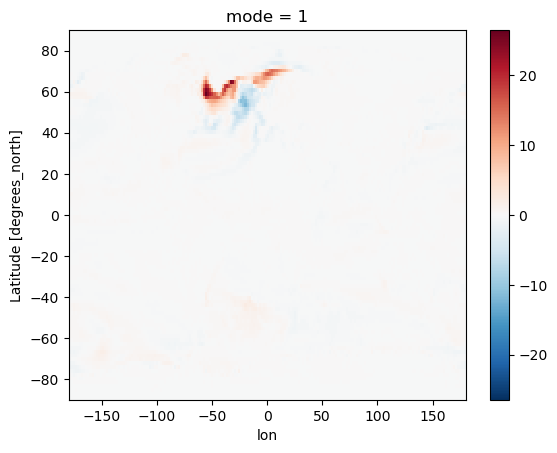

In [48]:
thf_reg[1].plot()

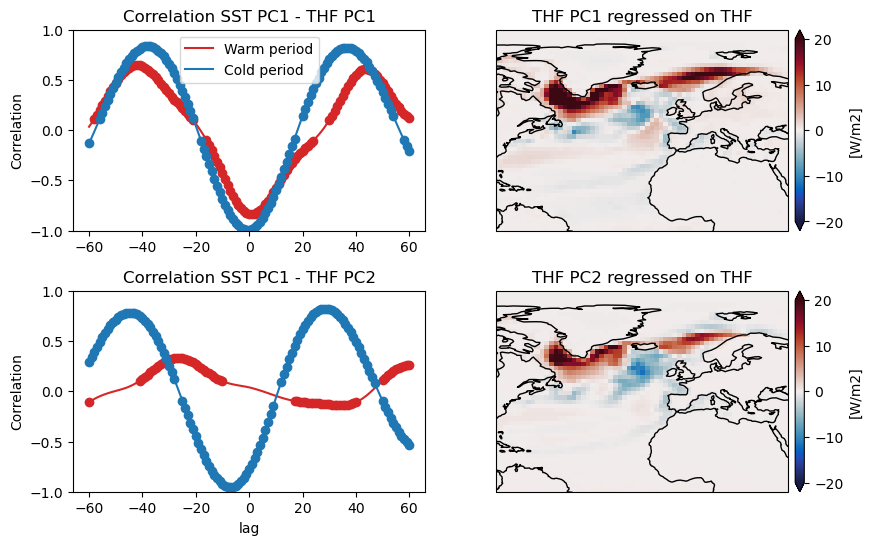

In [49]:
#fig1, ax1 = plt.subplots(2,2)
fig1 = plt.figure(figsize=(10,6))
ax1 = []
ax1.append(fig1.add_subplot(2,2,1))
ax1.append(fig1.add_subplot(2,2,2, projection=ccrs.PlateCarree()))
ax1.append(fig1.add_subplot(2,2,3))
ax1.append(fig1.add_subplot(2,2,4, projection=ccrs.PlateCarree()))
fig1.subplots_adjust(hspace=0.3)
#cax = fig1.add_axes([0.8,0.2,0.02,0.6])

# Plot PC1 correlation to THF PC1
ds_pc1_thf1[0]['corrcoef'].plot(ax=ax1[0], c='tab:red',label='Warm period')
ds_pc1_thf1[0]['corrcoef'].where(ds_pc1_thf1[0]['pval']<0.05).plot(ax=ax1[0], marker='o', lw=0, c='tab:red')
ds_pc1_thf1[1]['corrcoef'].plot(ax=ax1[0], c='tab:blue',label='Cold period')
ds_pc1_thf1[1]['corrcoef'].where(ds_pc1_thf1[1]['pval']<0.05).plot(ax=ax1[0], marker='o', lw=0, c='tab:blue')
ax1[0].set_title('Correlation SST PC1 - THF PC1')
ax1[0].set_xlabel('')
ax1[0].set_ylabel('Correlation')

# PC1 to THF PC2
ds_pc1_thf2[0]['corrcoef'].plot(ax=ax1[2], c='tab:red')
ds_pc1_thf2[0]['corrcoef'].where(ds_pc1_thf2[0]['pval']<0.05).plot(ax=ax1[2], marker='o', lw=0, c='tab:red')
ds_pc1_thf2[1]['corrcoef'].plot(ax=ax1[2], c='tab:blue')
ds_pc1_thf2[1]['corrcoef'].where(ds_pc1_thf2[1]['pval']<0.05).plot(ax=ax1[2], marker='o', lw=0, c='tab:blue')
ax1[2].set_title('Correlation SST PC1 - THF PC2')
ax1[2].set_ylabel('Correlation')

# Plot EOF1 of THF
ckw = {'pad':0.02, 'label':'[W/m2]', 'extend':'both'}
p1 = thf_reg[0].plot.pcolormesh(ax=ax1[1], 
                                vmin=-20, vmax=20,
                                #add_colorbar=False,
                                cmap=cmocean.cm.balance,
                                rasterized=True,
                                cbar_kwargs=ckw)
ax1[1].set_title('THF PC1 regressed on THF')
p2 = thf_reg[1].plot.pcolormesh(ax=ax1[3],
                                vmin=-20, vmax=20,
                                #add_colorbar=False,
                                cmap=cmocean.cm.balance,
                                rasterized=True,
                                cbar_kwargs=ckw)
#plt.colorbar(p1, cax=cax, orientation='vertical')
ax1[3].set_title('THF PC2 regressed on THF')

for ax in ax1[0::2]:
    ax.set_ylim([-1,1])

for ax in ax1[1::2]:
    ax.set_extent([-80,40,0,90])
    ax.coastlines()
    ax.set_aspect('auto')

ax1[0].legend()
fig1.savefig('figures/Fig_THF_EOF.pdf',format='pdf',dpi=150)